<a href="https://colab.research.google.com/github/GDG-on-Campus-METU/ai-ml-materials/blob/main/week6/week6_notebook.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>



---

# 00. About week6

---

1. Importing libraries
1. Convolutional Neural Networks
2. Transfer learning

**Note:** Outputs of training blocks did not removed. You can access results of trainings without running training blocks. (Training takes time.)

---

# 01. Importing libraries

---

In [ ]:
!pip install visualkeras

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 993.7/993.7 kB 15.2 MB/s eta 0:00:00


In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import tensorflow as tf
import tensorflow_datasets as tfds
import visualkeras
print(tf.__version__)

2.17.0


---

# 02. Convolutional Neural Networks

---

> https://poloclub.github.io/cnn-explainer/

## What is CNN ?

A Convolutional Neural Network (CNN) is a type of artificial neural network specifically designed for processing data with a grid-like topology, such as images.

CNNs are preferred for certain tasks, especially those involving image or spatial data, due to several key advantages:

1. Feature Extraction: CNNs automatically learn and extract relevant features from the input data through convolutional layers. This eliminates the need for manual feature engineering, which can be time-consuming and requires domain expertise.

2. Spatial Invariance: CNNs are designed to be translation invariant, meaning they can recognize patterns regardless of their position in the input image. This is achieved through the use of convolutional filters that slide across the entire image.

3. Parameter Sharing: The same filter is applied across different locations in the input image, significantly reducing the number of parameters compared to fully connected networks. This makes CNNs more efficient and less prone to overfitting.

4. Hierarchical Representation: CNNs learn hierarchical representations of the input data, with lower layers detecting simple features like edges and higher layers detecting more complex patterns. This allows for a more comprehensive understanding of the data.

5. Success in Image-Related Tasks: CNNs have achieved state-of-the-art results in various image-related tasks, including image classification, object detection, image segmentation, and image generation.

In summary, CNNs offer a powerful and efficient approach for processing and analyzing image data, making them a popular choice in computer vision and related fields.

## CNN Structure

A typical CNN structure consists of multiple layers arranged in a specific order to process and extract features from input data, typically images. Here's a breakdown of the common layers:

1. Input Layer: This layer receives the raw input image data.

2. Convolutional Layers: These layers apply a set of learnable filters (kernels) to the input image, extracting features like edges, corners, and textures. Each filter performs a convolution operation, sliding across the input and computing dot products.


3. Pooling Layers: These layers reduce the dimensionality of the feature maps obtained from convolutional layers, retaining important information and reducing computational complexity. Common pooling operations include max pooling and average pooling.

4. Fully Connected Layers: After several convolutional and pooling layers, the flattened feature maps are fed into fully connected layers. These layers learn to classify the input based on the extracted features.

5. Output Layer: The final layer produces the predicted output, typically a probability distribution over different classes. The number of neurons in this layer corresponds to the number of classes in the classification task.

Example Structure:

* Input Layer (Image)
* Convolutional Layer + ReLU Activation
* Pooling Layer
* Convolutional Layer + ReLU Activation
* Pooling Layer
* Flatten Layer (Convert feature maps to a 1D vector)
* Fully Connected Layer + ReLU Activation
* Output Layer (Softmax for classification)

This is a basic structure, and the number and types of layers can vary depending on the specific task and dataset.

## Deep vs Shallow Layers

**Deep Layers:**

* Located towards the end of the network.
* Extract high-level, abstract features.
* Capture complex patterns and relationships.
* Have larger receptive fields, considering a wider context.
* Represent information at a higher level of abstraction.

**Shallow Layers:**

* Located closer to the input of the network.
* Detect low-level features like edges, corners, textures.
* Serve as building blocks for more complex representations.
* Have smaller receptive fields, focusing on local details.
* Represent information at a lower level of abstraction.

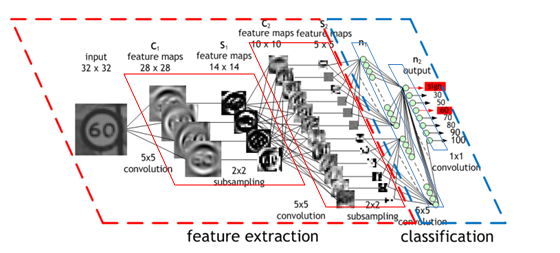

## Example: cats_vs_dogs

In [ ]:
data, ds_info = tfds.load(
    "cats_vs_dogs",
    split=["train"],
    shuffle_files = True,
    as_supervised = True,
    with_info = True
)

Dl Completed...: 0 url [00:00, ? url/s]

Dl Size...: 0 MiB [00:00, ? MiB/s]

Generating splits...:   0%|          | 0/1 [00:00<?, ? splits/s]

Generating train examples...:   0%|          | 0/23262 [00:00<?, ? examples/s]

Shuffling /root/tensorflow_datasets/cats_vs_dogs/incomplete.4BAWPK_4.0.1/cats_vs_dogs-train.tfrecord*...:   0%…

Dataset cats_vs_dogs downloaded and prepared to /root/tensorflow_datasets/cats_vs_dogs/4.0.1. Subsequent calls will reuse this data.


In [ ]:
ds_info.features

FeaturesDict({
    'image': Image(shape=(None, None, 3), dtype=uint8),
    'image/filename': Text(shape=(), dtype=string),
    'label': ClassLabel(shape=(), dtype=int64, num_classes=2),
})

In [ ]:
class_names = ds_info.features["label"].names
class_names

['cat', 'dog']

In [ ]:
DATASET_SIZE = 23262

train_size = int(0.8 * DATASET_SIZE)

full_data = data[0].shuffle(buffer_size=100)
train_data = full_data.take(train_size)
test_data = full_data.skip(train_size)

In [ ]:
sample_img = test_data.take(1)
for image, label in sample_img:
    print(f"""
    Image shape: {image.shape}
    Image dtype: {image.dtype}
    Target class: {label}
    Class name: {class_names[label.numpy()]}
    """)


    Image shape: (500, 335, 3)
    Image dtype: <dtype: 'uint8'>
    Target class: 1
    Class name: dog
    


In [ ]:
tf.reduce_min(image), tf.reduce_max(image)

(<tf.Tensor: shape=(), dtype=uint8, numpy=10>,
 <tf.Tensor: shape=(), dtype=uint8, numpy=241>)

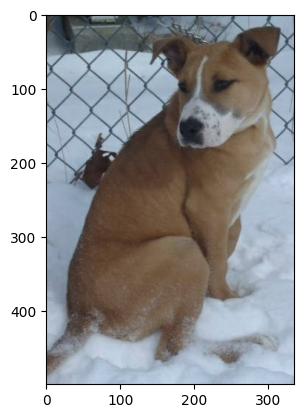

In [ ]:
plt.imshow(image)

In [ ]:
def preprocess_img(image, label, img_shape=300, rescale=False):
    image = tf.image.resize(image, [img_shape, img_shape])
    if rescale==False:
        return tf.cast(image, tf.float32), label
    else:
        return tf.cast(image, tf.float32)/255., label

In [ ]:
train_data = train_data.map(map_func=preprocess_img, num_parallel_calls=tf.data.AUTOTUNE).batch(32).prefetch(buffer_size=tf.data.AUTOTUNE)
test_data = test_data.map(map_func=preprocess_img, num_parallel_calls=tf.data.AUTOTUNE).batch(32).prefetch(buffer_size=tf.data.AUTOTUNE)

In [ ]:
train_data, test_data

(<_PrefetchDataset element_spec=(TensorSpec(shape=(None, 300, 300, 3), dtype=tf.float32, name=None), TensorSpec(shape=(None,), dtype=tf.int64, name=None))>,
 <_PrefetchDataset element_spec=(TensorSpec(shape=(None, 300, 300, 3), dtype=tf.float32, name=None), TensorSpec(shape=(None,), dtype=tf.int64, name=None))>)

In [ ]:
cnn_model = tf.keras.models.Sequential([
    tf.keras.layers.Input(shape=(300,300,3)),
    tf.keras.layers.Rescaling(1./255),
    tf.keras.layers.Conv2D(16, 3, 1, padding="valid", activation="relu"),
    tf.keras.layers.MaxPool2D(2,2, padding="same"),
    tf.keras.layers.Conv2D(32, 3, 1, padding="valid", activation="relu"),
    tf.keras.layers.MaxPool2D(2,2, padding="same"),
    tf.keras.layers.Conv2D(64, 3, 1, padding="valid", activation="relu"),
    tf.keras.layers.MaxPool2D(2,2, padding="same"),
    tf.keras.layers.Conv2D(128, 3, 1, padding="valid", activation="relu"),
    tf.keras.layers.MaxPool2D(2,2, padding="same"),
    tf.keras.layers.Conv2D(256, 3, 1, padding="valid", activation="relu"),
    tf.keras.layers.MaxPool2D(2,2, padding="same"),
    tf.keras.layers.Conv2D(512, 3, 1, padding="valid", activation="relu"),
    tf.keras.layers.MaxPool2D(2,2, padding="same"),
    tf.keras.layers.GlobalMaxPooling2D(),
    tf.keras.layers.Dense(1024, activation="relu"),
    tf.keras.layers.Dense(1, activation="sigmoid")
])

In [ ]:
cnn_model.summary()

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ rescaling (Rescaling)                │ (None, 300, 300, 3)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d (Conv2D)                      │ (None, 298, 298, 16)        │             448 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d (MaxPooling2D)         │ (None, 149, 149, 16)        │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_1 (Conv2D)                    │ (None, 147, 147, 32)        │           4,640 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_1 (MaxPooling2D)       │ (None, 74, 74, 32)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_2 (Conv2D)                    │ (None, 72, 72, 64)          │          18,496 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_2 (MaxPooling2D)       │ (None, 36, 36, 64)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_3 (Conv2D)                    │ (None, 34, 34, 128)         │          73,856 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_3 (MaxPooling2D)       │ (None, 17, 17, 128)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_4 (Conv2D)                    │ (None, 15, 15, 256)         │         295,168 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_4 (MaxPooling2D)       │ (None, 8, 8, 256)           │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_5 (Conv2D)                    │ (None, 6, 6, 512)           │       1,180,160 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_5 (MaxPooling2D)       │ (None, 3, 3, 512)           │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ global_max_pooling2d                 │ (None, 512)                 │               0 │
│ (GlobalMaxPooling2D)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense (Dense)                        │ (None, 1024)                │         525,312 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_1 (Dense)                      │ (None, 1)                   │           1,025 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 2,099,105 (8.01 MB)

 Trainable params: 2,099,105 (8.01 MB)

 Non-trainable params: 0 (0.00 B)

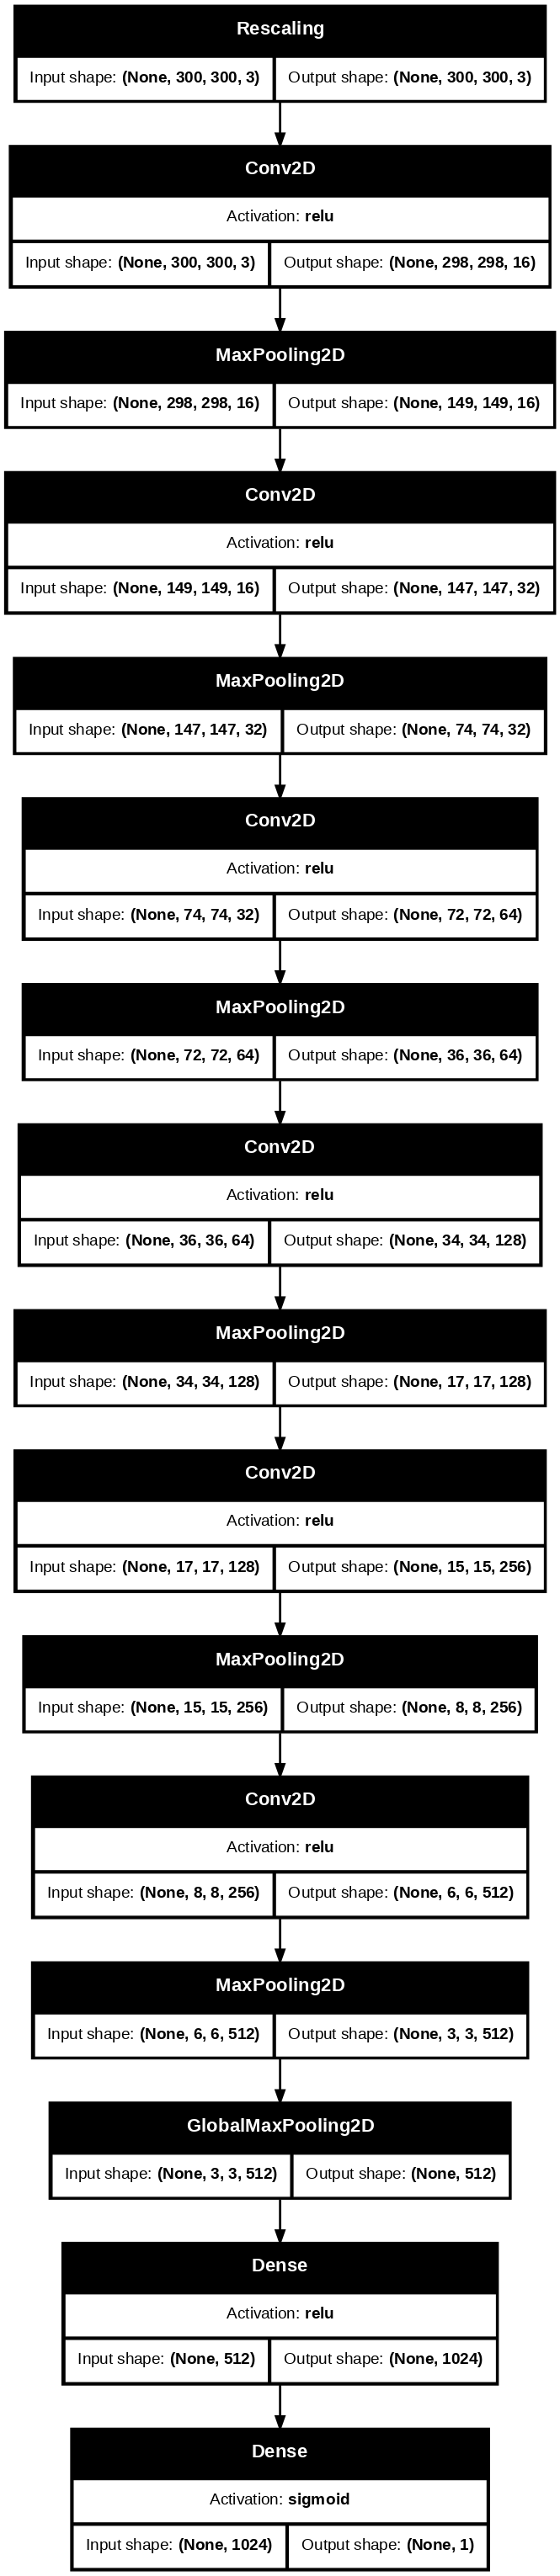

In [ ]:
tf.keras.utils.plot_model(cnn_model, show_shapes=True, show_layer_activations=True, dpi=100)

/usr/local/lib/python3.10/dist-packages/visualkeras/layered.py:86: UserWarning: The legend_text_spacing_offset parameter is deprecated and will be removed in a future release.
  warnings.warn("The legend_text_spacing_offset parameter is deprecated and will be removed in a future release.")


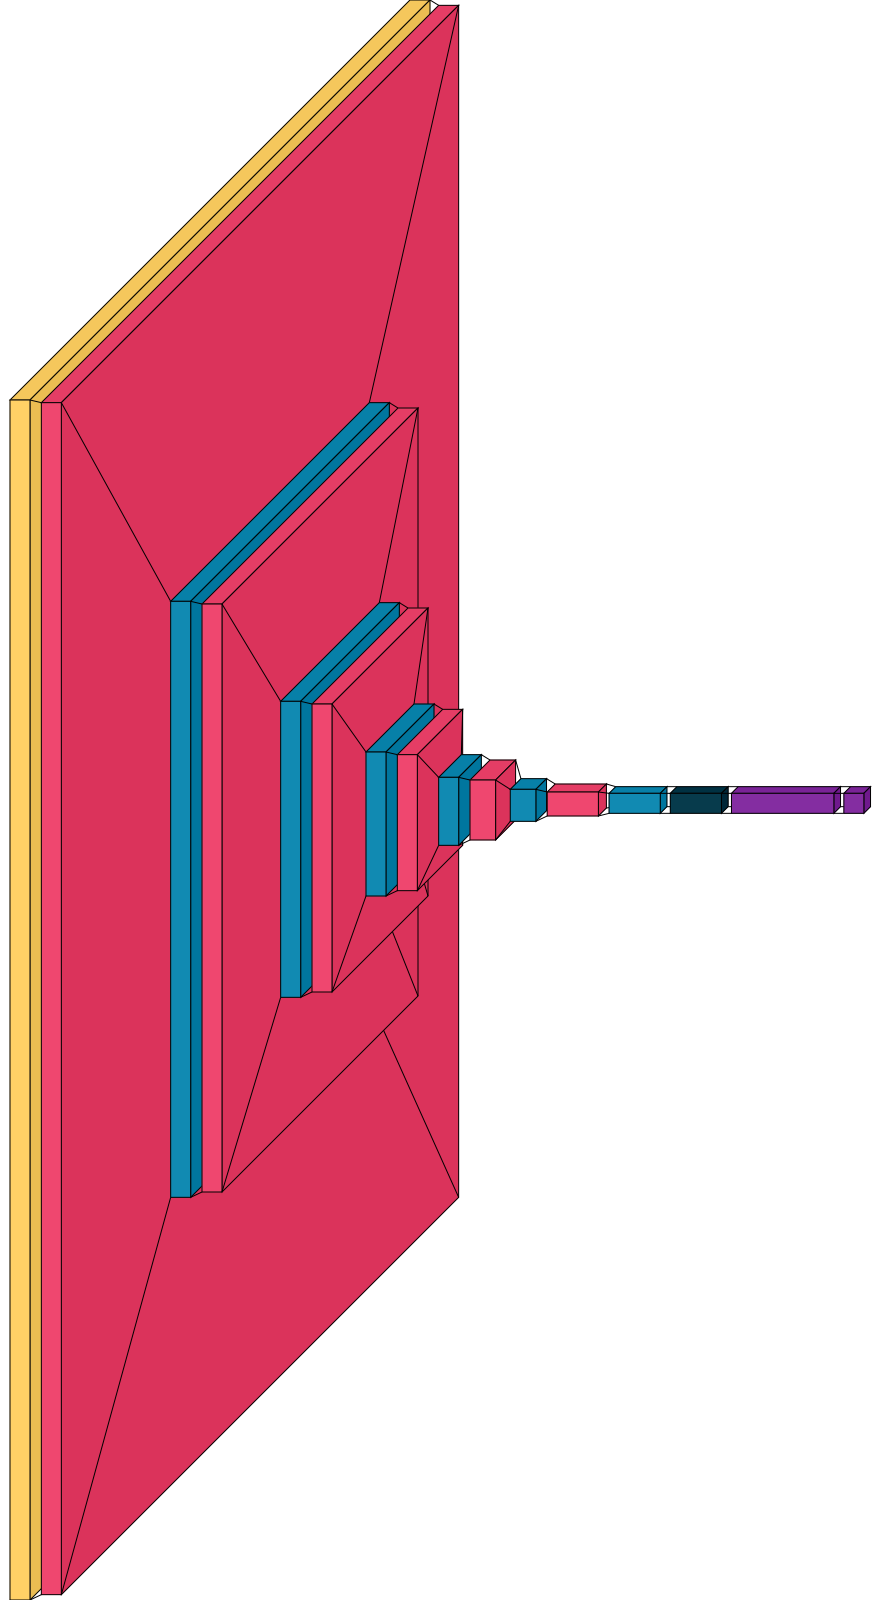

In [ ]:
visualkeras.layered_view(cnn_model)

In [ ]:
cnn_model.compile(loss=tf.keras.losses.BinaryCrossentropy(),
                  optimizer=tf.keras.optimizers.Adam(),
                  metrics=['accuracy'])

In [ ]:
cnn_history = cnn_model.fit(train_data, validation_data=test_data, epochs=20, verbose=1)

Epoch 1/20
582/582 ━━━━━━━━━━━━━━━━━━━━ 107s 164ms/step - accuracy: 0.5197 - loss: 0.6953 - val_accuracy: 0.5573 - val_loss: 0.6822
Epoch 2/20
582/582 ━━━━━━━━━━━━━━━━━━━━ 67s 116ms/step - accuracy: 0.5608 - loss: 0.6785 - val_accuracy: 0.6323 - val_loss: 0.6354
Epoch 3/20
582/582 ━━━━━━━━━━━━━━━━━━━━ 67s 115ms/step - accuracy: 0.6676 - loss: 0.6079 - val_accuracy: 0.7041 - val_loss: 0.5754
Epoch 4/20
582/582 ━━━━━━━━━━━━━━━━━━━━ 98s 143ms/step - accuracy: 0.7461 - loss: 0.5159 - val_accuracy: 0.7498 - val_loss: 0.5014
Epoch 5/20
582/582 ━━━━━━━━━━━━━━━━━━━━ 67s 114ms/step - accuracy: 0.8052 - loss: 0.4201 - val_accuracy: 0.8461 - val_loss: 0.3479
Epoch 6/20
582/582 ━━━━━━━━━━━━━━━━━━━━ 82s 115ms/step - accuracy: 0.8593 - loss: 0.3169 - val_accuracy: 0.8564 - val_loss: 0.3353
Epoch 7/20
582/582 ━━━━━━━━━━━━━━━━━━━━ 83s 143ms/step - accuracy: 0.8992 - loss: 0.2375 - val_accuracy: 0.8425 - val_loss: 0.3847
Epoch 8/20
582/582 ━━━━━━━━━━━━━━━━━━━━ 83s 143ms/step - accuracy: 0.9275 - loss: 

In [ ]:
cnn_model.evaluate(test_data)

146/146 ━━━━━━━━━━━━━━━━━━━━ 25s 65ms/step - accuracy: 0.8848 - loss: 0.4525


[0.5148747563362122, 0.8734149932861328]

<Axes: >

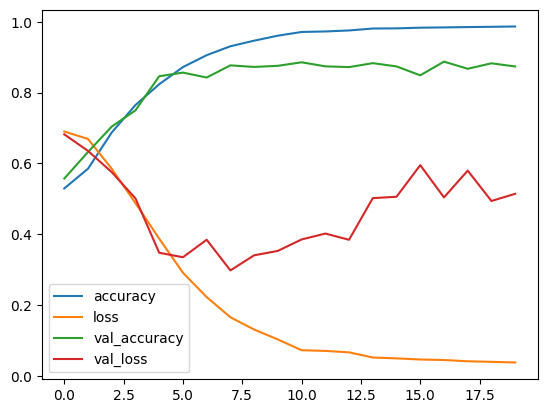

In [ ]:
pd.DataFrame(cnn_history.history).plot()

---

# 03. Transfer learning

---

## What is transfer learning ?

Transfer learning is a machine learning technique where a model developed for one task is reused as a starting point for a model on a second task.

**Key Points:**

* **Leverages Existing Knowledge:** Instead of training a model from scratch, you use a pre-trained model that has already learned useful features from a large dataset.
* **Efficiency:** This saves time and computational resources, especially when you have limited data for the new task.
* **Improved Performance:** The pre-trained model's knowledge often leads to better performance on the new task compared to training from scratch.
* **Common in Deep Learning:** Widely used in areas like image recognition and natural language processing, where large pre-trained models are readily available.

**Think of it like this:** Imagine you've learned to play the piano. Learning a new instrument, like the guitar, becomes easier because you already understand music theory and have developed finger dexterity. Transfer learning applies a similar concept to machine learning models.

## Transfer learning for image classification

Transfer learning in image classification involves using a pre-trained model, typically trained on a large dataset like ImageNet, and adapting it to a new, related task with a smaller dataset.

**Steps:**

1. **Choose a Pre-trained Model:** Select a model architecture (e.g., ResNet, VGG, Inception) that has been pre-trained on a large image dataset. These models have learned to extract general features from images.

2. **Freeze Layers:** Freeze the weights of the early layers of the pre-trained model. These layers have learned to detect generic features like edges, textures, and shapes, which are useful for a variety of image tasks.

3. **Add New Layers:** Replace the final fully connected layers of the pre-trained model with new layers specific to your task. These layers will learn to classify images based on the features extracted by the frozen layers.

4. **Train the Model:** Train the new layers on your smaller dataset. The frozen layers act as feature extractors, providing a strong starting point for your model.

**Benefits:**

* **Reduced Training Time and Data:** Transfer learning requires less training time and data compared to training a model from scratch.
* **Improved Performance:** Leveraging the knowledge from a pre-trained model often leads to better performance, especially with limited data.
* **Generalization:** The pre-trained model's ability to extract general features helps your model generalize better to new images.

## Example: EfficientNet on cats_vs_dogs

In [ ]:
base_model = tf.keras.applications.EfficientNetB3(include_top=False)
base_model.trainable = False

inputs = tf.keras.layers.Input(shape=(300, 300, 3))
x = base_model(inputs, training=False)
x = tf.keras.layers.GlobalAveragePooling2D()(x)
outputs = tf.keras.layers.Dense(1, activation="sigmoid")(x)

efficientnet_model = tf.keras.models.Model(inputs, outputs)

43941136/43941136 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step


In [ ]:
efficientnet_model.compile(
    loss = tf.keras.losses.binary_crossentropy,
    optimizer = tf.keras.optimizers.Adam(),
    metrics = ["accuracy"]
)

In [ ]:
efficientnet_model.summary()

Model: "functional_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ input_layer_2 (InputLayer)           │ (None, 300, 300, 3)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ efficientnetb3 (Functional)          │ (None, 9, 9, 1536)          │      10,783,535 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ global_average_pooling2d             │ (None, 1536)                │               0 │
│ (GlobalAveragePooling2D)             │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_2 (Dense)                      │ (None, 1)                   │           1,537 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 10,785,072 (41.14 MB)

 Trainable params: 1,537 (6.00 KB)

 Non-trainable params: 10,783,535 (41.14 MB)

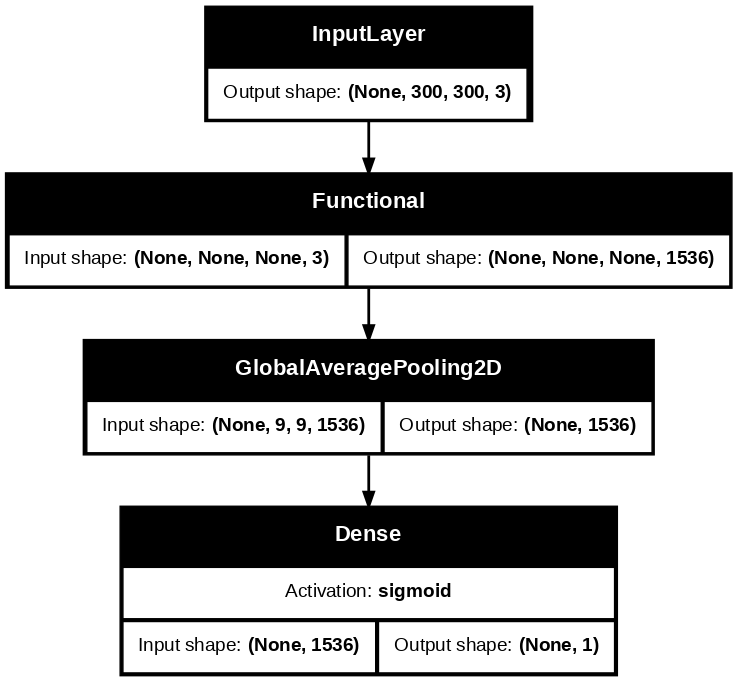

In [ ]:
tf.keras.utils.plot_model(efficientnet_model, show_shapes=True, show_layer_activations=True, dpi=100)

In [ ]:
enet_history = efficientnet_model.fit(train_data, validation_data=test_data, epochs=3, verbose=1)

Epoch 1/3
582/582 ━━━━━━━━━━━━━━━━━━━━ 214s 299ms/step - accuracy: 0.9632 - loss: 0.1380 - val_accuracy: 0.9936 - val_loss: 0.0235
Epoch 2/3
582/582 ━━━━━━━━━━━━━━━━━━━━ 110s 188ms/step - accuracy: 0.9942 - loss: 0.0221 - val_accuracy: 0.9948 - val_loss: 0.0175
Epoch 3/3
582/582 ━━━━━━━━━━━━━━━━━━━━ 101s 174ms/step - accuracy: 0.9934 - loss: 0.0189 - val_accuracy: 0.9955 - val_loss: 0.0160


In [ ]:
efficientnet_model.evaluate(test_data)

<Axes: >

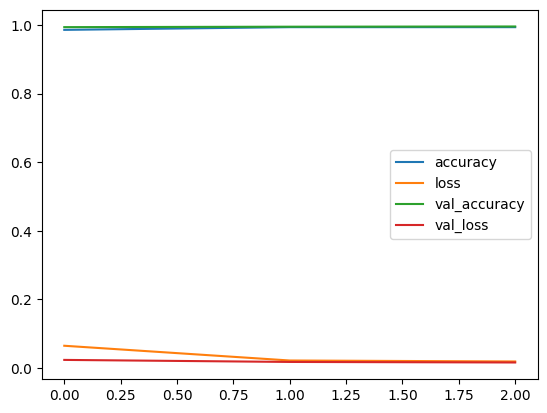

In [ ]:
pd.DataFrame(enet_history.history).plot()

## EfficientNetB3 Architecture

dot: graph is too large for cairo-renderer bitmaps. Scaling by 0.442881 to fit



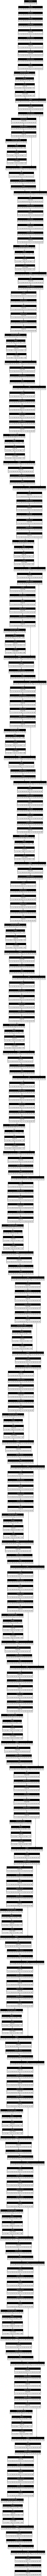

In [ ]:
tf.keras.utils.plot_model(base_model, show_shapes=True, show_layer_activations=True, dpi=100)

## Pre-trained models for image classification performance comparison


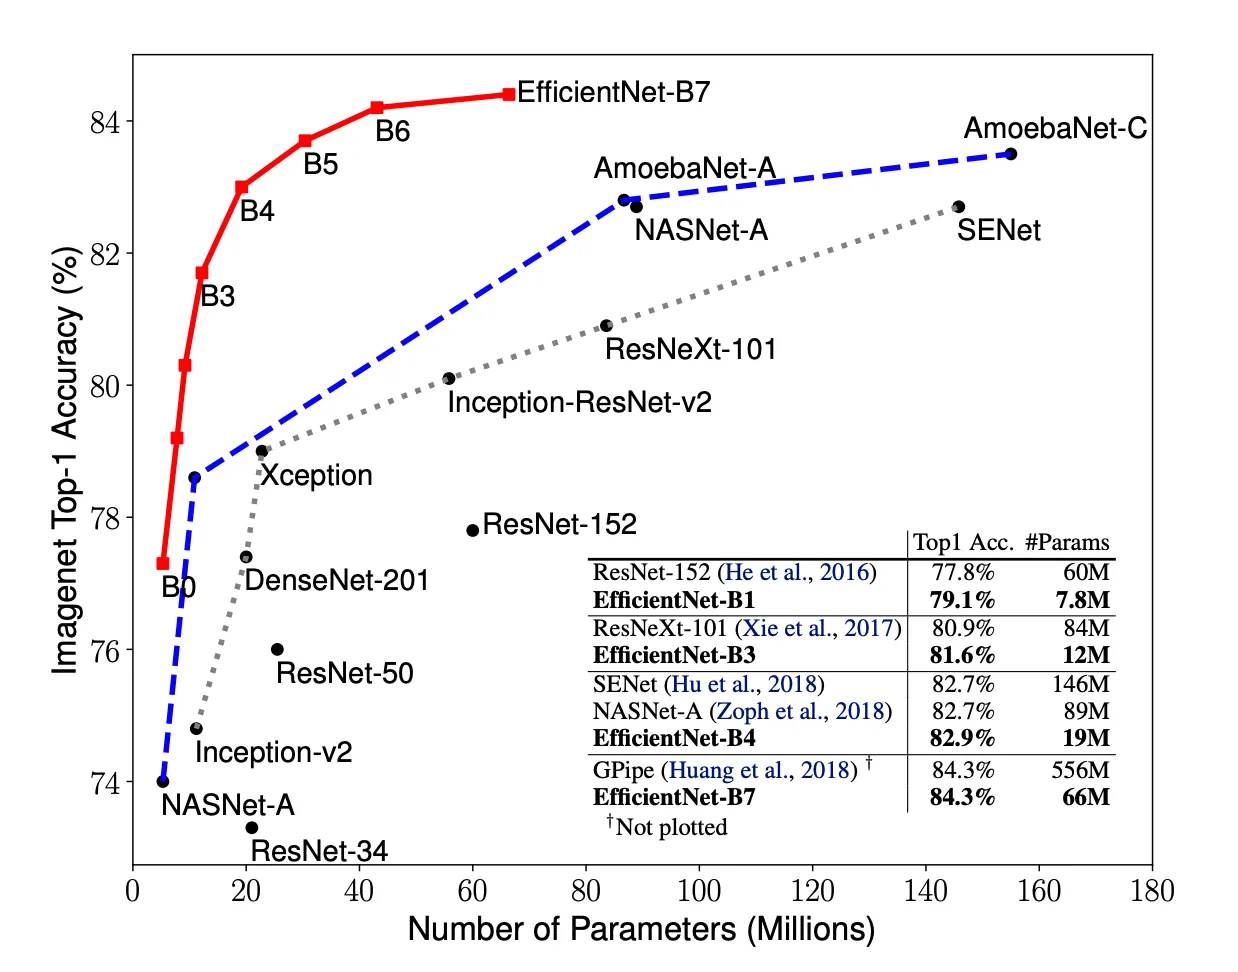